In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_6581/4205361466.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df['Close'].resample('M').last()


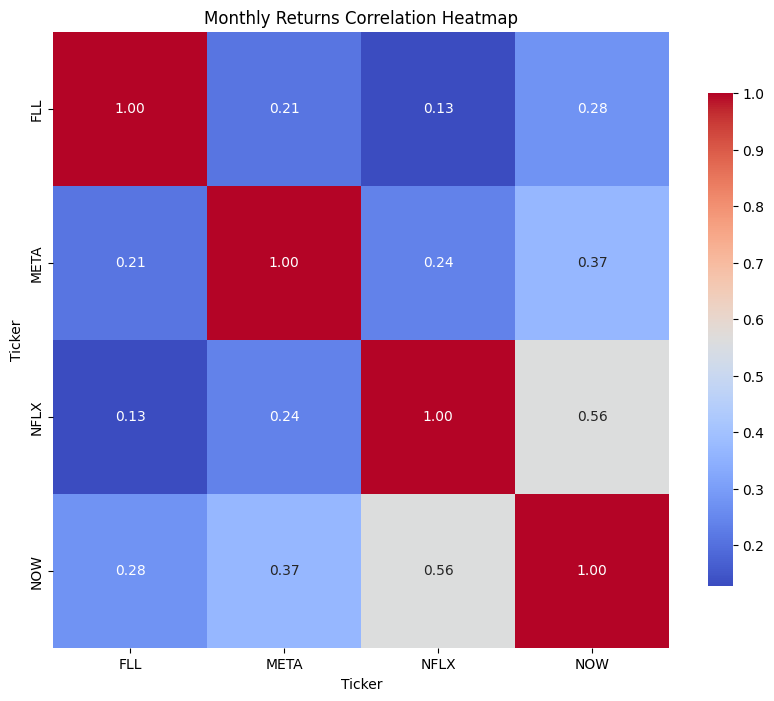

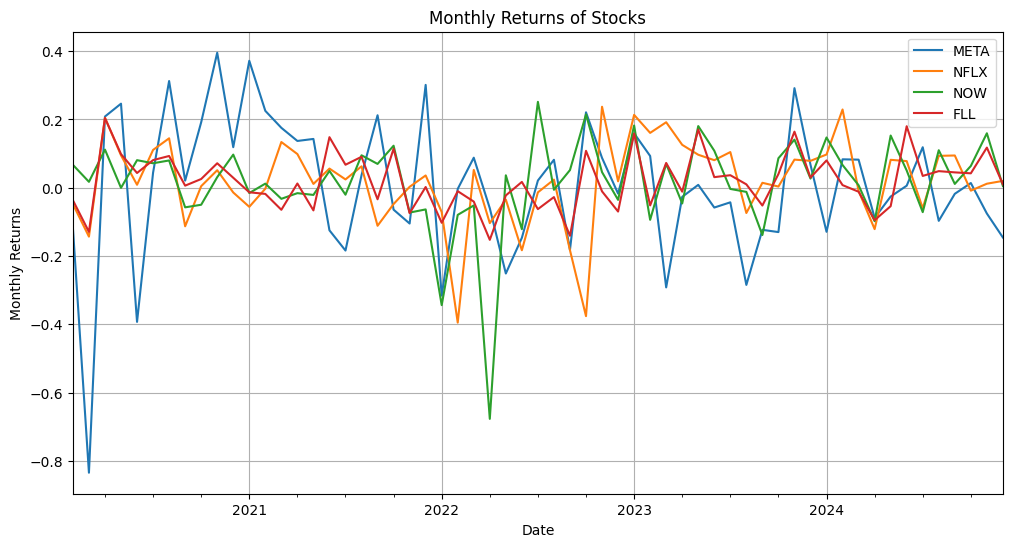

In [3]:
#import all 4 stocks 

stocks = ['META', 'NFLX', 'NOW', 'FLL']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')
# Resample to monthly frequency
df = df['Close'].resample('M').last()
# Calculate monthly returns
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
#plot the heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(monthly_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Monthly Returns Correlation Heatmap')
plt.show()

#plot the returns of each stock
log_returns.plot(figsize=(12, 6))
plt.title('Monthly Returns of Stocks')
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.legend(stocks)
plt.grid()
plt.show()

[*********************100%***********************]  4 of 4 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_6581/710475586.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').last()


Mean Squared Error: 0.0316


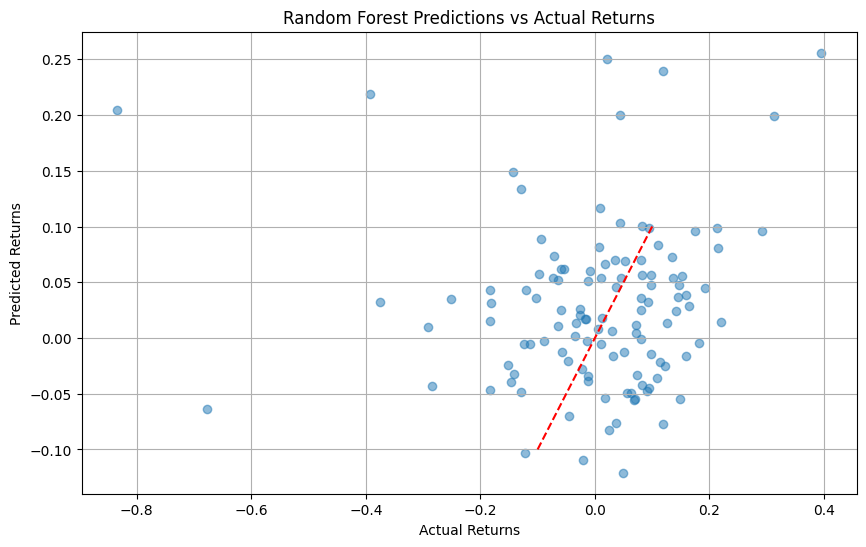

Ticker       FLL      META      NFLX       NOW
Date                                          
2      -0.033525  0.056776 -0.035433 -0.006532
3      -0.030106  0.056333 -0.023120 -0.004104
4      -0.031069  0.051401 -0.029103 -0.005975
5      -0.023442  0.059876 -0.012431  0.003970
6      -0.028721  0.049464 -0.029913 -0.007284
7       0.021457  0.096212 -0.001847  0.006741
8       0.037633  0.101438  0.011238  0.014208
9       0.031560  0.105363  0.017574  0.029698
10      0.075841  0.096508  0.031358  0.030809
11      0.067112  0.099627  0.021578  0.036829
12      0.005915  0.066696 -0.027769  0.025474


<Figure size 1200x600 with 0 Axes>

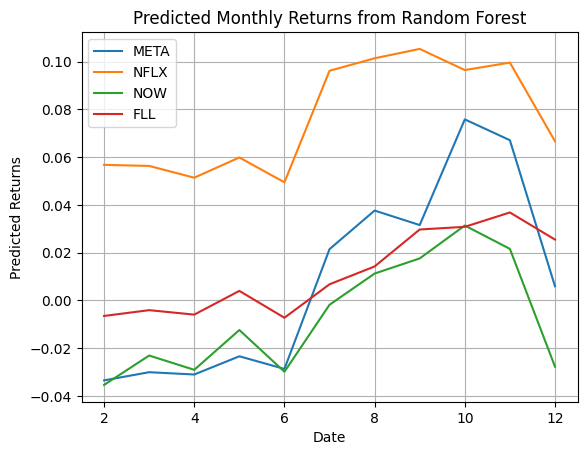

In [8]:
#set random forest parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Prepare the data for Random Forest

stocks = ['META', 'NFLX', 'NOW', 'FLL']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')['Close']
df = df.resample('M').last()
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
price_series = df

X = price_series.shift(1).dropna().values
y = log_returns.shift(-1).dropna().values

# realigning matrices
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
# Make predictions
y_pred = rf_model.predict(X_test)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
# Plot the predictions vs actual returns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Random Forest Predictions vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()
plt.show()

#get predicted pooled returns
price_series_aggregated = price_series.groupby(price_series.index.month).mean()

predicted_returns = rf_model.predict(price_series_aggregated.shift(1).dropna().values)

# Align predicted returns with the correct index and columns
predicted_returns = pd.DataFrame(predicted_returns, index=price_series_aggregated.index[1:], columns=price_series.columns)
print(predicted_returns)
plt.figure(figsize=(12, 6))
predicted_returns.plot()
plt.title('Predicted Monthly Returns from Random Forest')
plt.xlabel('Date')
plt.ylabel('Predicted Returns')
plt.legend(stocks)
plt.grid()
plt.show()


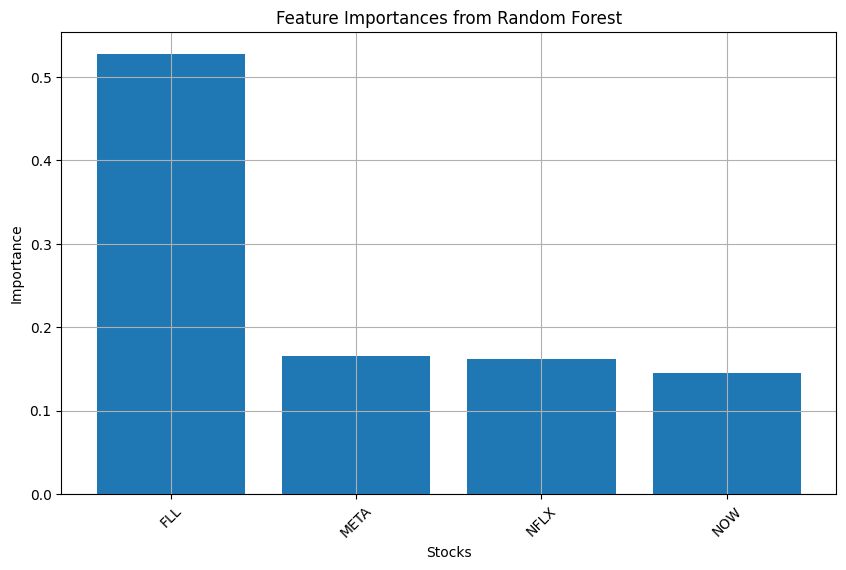

In [9]:
#plot the importance of each stock
importances = rf_model.feature_importances_
feature_names = price_series.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Stocks')
plt.ylabel('Importance')
plt.grid()
plt.show()

In [10]:
#Set optimal portfolio weights based on the predicted returns USING MARKOVITZ
from scipy.optimize import minimize

muh = price_series.mean()
sigma = price_series.cov()
def portfolio_variance(weights, sigma):
    return np.dot(weights.T, np.dot(sigma, weights))

weights_initial = np.array([1/len(stocks)] * len(stocks))
def objective_function(weights, mu, sigma):
    return -np.dot(weights, mu) / np.sqrt(portfolio_variance(weights, sigma)) #muh*weight/sigma
def constraint_sum(weights):
    return np.sum(weights) - 1
# Constraints and bounds
constraints = {'type': 'eq', 'fun': constraint_sum}
bounds = tuple((0, 1) for _ in range(len(stocks)))
# Optimize the portfolio weights
result = minimize(objective_function, weights_initial, args=(muh, sigma), method='SLSQP', bounds=bounds, constraints=constraints) #Assign convex optimiser
optimal_weights = result.x
print(f'Optimal Weights: {optimal_weights}')
#print stock names and their corresponding weights
for stock, weight in zip(stocks, optimal_weights):
    print(f'{stock}: {weight:.4f}')

Optimal Weights: [0.97482769 0.         0.01074581 0.0144265 ]
META: 0.9748
NFLX: 0.0000
NOW: 0.0107
FLL: 0.0144


In [13]:
#pass feedforward neural network parameters and get optimal criteria
from sklearn.neural_network import MLPRegressor
# Set up a feedforward neural network (MLPRegressor) to predict returns

# Prepare features (X) and target (y)
# Here, as an example, we use past price data to predict next period returns
# You may want to adjust this to your specific use case

# Calculate returns
returns = price_series.pct_change().dropna()

# set all neural network parameters



# Use previous returns as features to predict next period return for each stock
# For simplicity, let's predict the return of the first stock
target_stock = stocks[0]
X = returns.shift(1).dropna()
y = returns[target_stock].loc[X.index]

# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the neural network
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

# Train the neural network
mlp.fit(X_train, y_train)

# Evaluate performance
train_score = mlp.score(X_train, y_train)
test_score = mlp.score(X_test, y_test)
print(f"MLPRegressor train R^2: {train_score:.4f}")
print(f"MLPRegressor test R^2: {test_score:.4f}")

# Predict next period return for the target stock
next_X = returns.iloc[[-1]]
predicted_return = mlp.predict(next_X)
print(f"Predicted next period return for {target_stock}: {predicted_return[0]:.4%}")
#align predicted return with the correct index and columns
predicted_return = pd.DataFrame(predicted_return, index=returns.index[1:], columns=[target_stock])
print(predicted_return)

#plot predicted return vs actual return
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_return, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Predicted Return vs Actual Return')
plt.xlabel('Actual Return')
plt.ylabel('Predicted Return')
plt.grid()
plt.show()


MLPRegressor train R^2: 0.1736
MLPRegressor test R^2: -0.2099
Predicted next period return for META: 0.4701%


ValueError: Shape of passed values is (1, 1), indices imply (58, 1)